![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Caminhos dos arquivos
filename_features = r"C:\Users\Joel\Downloads\Data Scientist\Mod 27\M27 E M29\M27 E M29\features.txt"
filename_labels = r"C:\Users\Joel\Downloads\Data Scientist\Mod 27\M27 E M29\M27 E M29\activity_labels.txt"

filename_subtrain = r"C:\Users\Joel\Downloads\Data Scientist\Mod 27\M27 E M29\M27 E M29\train\subject_train.txt"
filename_xtrain = r"C:\Users\Joel\Downloads\Data Scientist\Mod 27\M27 E M29\M27 E M29\train\X_train.txt"
filename_ytrain = r"C:\Users\Joel\Downloads\Data Scientist\Mod 27\M27 E M29\M27 E M29\train\y_train.txt"

filename_subtest = r"C:\Users\Joel\Downloads\Data Scientist\Mod 27\M27 E M29\M27 E M29\test\subject_test.txt"
filename_xtest = r"C:\Users\Joel\Downloads\Data Scientist\Mod 27\M27 E M29\M27 E M29\test\X_test.txt"
filename_ytest = r"C:\Users\Joel\Downloads\Data Scientist\Mod 27\M27 E M29\M27 E M29\test\y_test.txt"

# Carregando os dados
features = pd.read_csv(filename_features, header=None, delim_whitespace=True, names=['index', 'nome_var'])
features = features['nome_var']  # Seleciona apenas o nome das variáveis

# Adicionando um índice único para duplicatas
if features.duplicated().any():
    print("Detectadas colunas duplicadas. Renomeando-as para serem únicas.")
    features = features + "_" + features.groupby(features).cumcount().astype(str)

# Carregando os rótulos das atividades
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

# Dados de treino
subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id']).squeeze()
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label']).squeeze()

# Dados de teste
subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id']).squeeze()
X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label']).squeeze()

# Verificando os dados
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Nomes das colunas únicas? {'Sim' if X_train.columns.is_unique else 'Não'}")

Detectadas colunas duplicadas. Renomeando-as para serem únicas.
Shape de X_train: (7352, 561)
Shape de X_test: (2947, 561)
Nomes das colunas únicas? Sim


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [29]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

CPU times: total: 172 ms
Wall time: 173 ms


,tBodyAcc-mean()-X_0,tBodyAcc-mean()-Y_0,tBodyAcc-mean()-Z_0,tBodyAcc-std()-X_0,tBodyAcc-std()-Y_0,tBodyAcc-std()-Z_0,tBodyAcc-mad()-X_0,tBodyAcc-mad()-Y_0,tBodyAcc-mad()-Z_0,tBodyAcc-max()-X_0,...,fBodyBodyGyroJerkMag-meanFreq()_0,fBodyBodyGyroJerkMag-skewness()_0,fBodyBodyGyroJerkMag-kurtosis()_0,"angle(tBodyAccMean,gravity)_0","angle(tBodyAccJerkMean),gravityMean)_0","angle(tBodyGyroMean,gravityMean)_0","angle(tBodyGyroJerkMean,gravityMean)_0","angle(X,gravityMean)_0","angle(Y,gravityMean)_0","angle(Z,gravityMean)_0"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222



PCA sem Padronização
Variância explicada por componente: [0.6255444  0.04913023 0.04121467 0.01874956 0.0169486  0.01272069
 0.01176685 0.01068973 0.0096938  0.00858018 0.00762302 0.00672446
 0.0057942  0.00557881 0.00498926 0.00474938 0.004672   0.00431618
 0.00425715 0.00410395 0.00394002 0.00375309 0.00352427 0.00339359
 0.00332139 0.00319429 0.00301779 0.00291783 0.0028957  0.00281928
 0.00276704 0.00263395 0.00255307 0.00235866 0.00230652 0.00223648
 0.00222948 0.00210276 0.00208393 0.00204774 0.00192856 0.0018888
 0.0018118  0.00179473 0.00172328 0.00160202 0.00157039 0.00156627
 0.0015297  0.00150351 0.00145118 0.0014064  0.00136825 0.00126858
 0.00125006 0.00119742 0.0011812  0.00114995 0.00113082 0.0010967
 0.00107704 0.001049   0.00103894 0.00101474 0.00099152 0.00097025
 0.0009541 ]
Variância explicada acumulada por componente: [0.6255444  0.67467463 0.7158893  0.73463886 0.75158746 0.76430816
 0.77607501 0.78676474 0.79645854 0.80503872 0.81266174 0.81938619
 0.82518039 0.

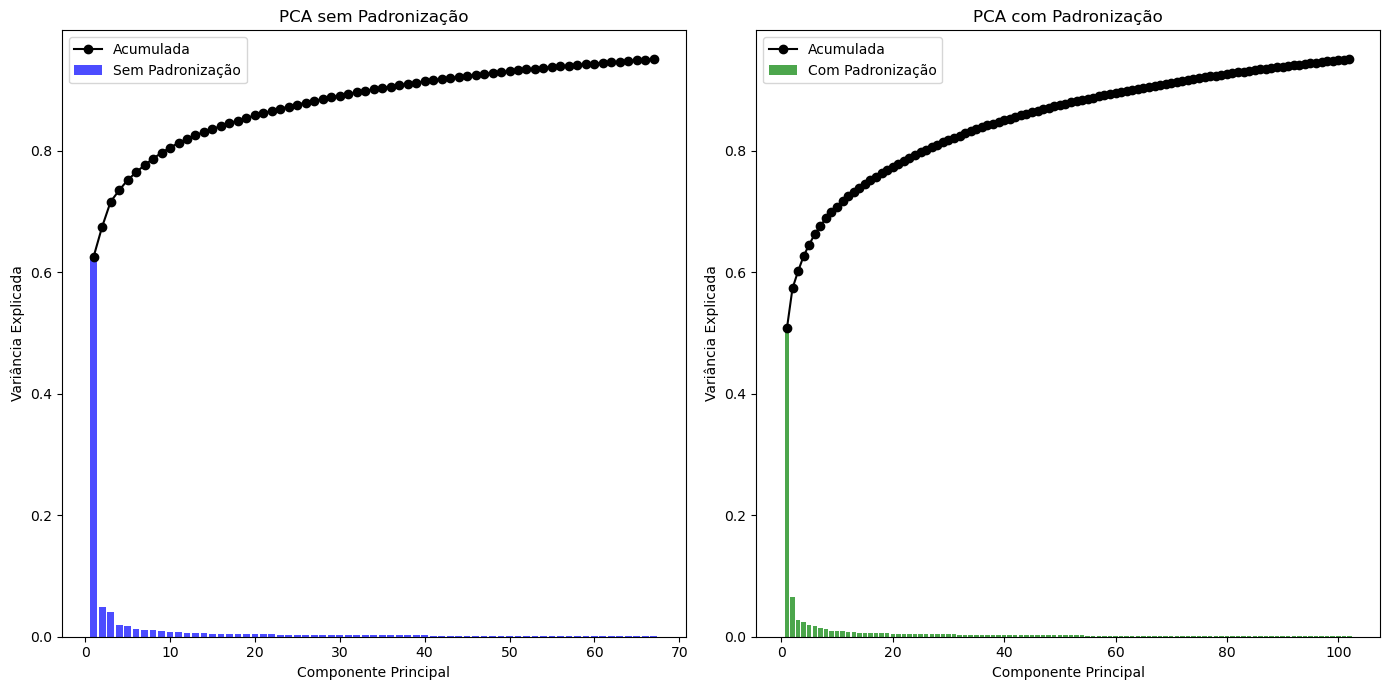

In [34]:
# 1. PCA sem padronização

# Aplicando PCA sem padronização
pca_without_scaling = PCA(n_components=0.95)  # Retenção de 95% da variância
X_train_pca_without_scaling = pca_without_scaling.fit_transform(X_train)
X_test_pca_without_scaling = pca_without_scaling.transform(X_test)

# Variância explicada
explained_variance_without_scaling = pca_without_scaling.explained_variance_ratio_
explained_variance_cumulative_without_scaling = explained_variance_without_scaling.cumsum()

# 2. PCA com padronização

# Padronizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicando PCA com padronização
pca_with_scaling = PCA(n_components=0.95)  # Retenção de 95% da variância
X_train_pca_with_scaling = pca_with_scaling.fit_transform(X_train_scaled)
X_test_pca_with_scaling = pca_with_scaling.transform(X_test_scaled)

# Variância explicada
explained_variance_with_scaling = pca_with_scaling.explained_variance_ratio_
explained_variance_cumulative_with_scaling = explained_variance_with_scaling.cumsum()

# 3. Comparando os resultados

# Função para exibir resultados
def display_results(explained_variance, explained_variance_cumulative, title):
    print(f"\n{title}")
    print(f"Variância explicada por componente: {explained_variance}")
    print(f"Variância explicada acumulada por componente: {explained_variance_cumulative}")
    
    # Variância percentual por componente
    variance_percent = explained_variance * 100
    print(f"Variância percentual por componente: {variance_percent}")
    
    # Variância percentual acumulada por componente
    variance_percent_cumulative = explained_variance_cumulative * 100
    print(f"Variância percentual acumulada por componente: {variance_percent_cumulative}")
    
    # Determinar quantas componentes explicam 90% da variância
    n_components_90 = (explained_variance_cumulative >= 0.90).argmax() + 1
    print(f"Quantidade de componentes para explicar 90% da variância: {n_components_90}\n")

# Exibindo resultados para PCA sem padronização
display_results(explained_variance_without_scaling, explained_variance_cumulative_without_scaling, "PCA sem Padronização")

# Exibindo resultados para PCA com padronização
display_results(explained_variance_with_scaling, explained_variance_cumulative_with_scaling, "PCA com Padronização")

# 4. Plotando as variâncias explicadas
plt.figure(figsize=(14, 7))

# Plotando a variância explicada por componente
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_without_scaling) + 1), explained_variance_without_scaling, alpha=0.7, color='blue', label='Sem Padronização')
plt.plot(range(1, len(explained_variance_without_scaling) + 1), explained_variance_cumulative_without_scaling, marker='o', label='Acumulada', color='black')
plt.title('PCA sem Padronização')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada')
plt.legend()

# Plotando a variância explicada por componente com padronização
plt.subplot(1, 2, 2)
plt.bar(range(1, len(explained_variance_with_scaling) + 1), explained_variance_with_scaling, alpha=0.7, color='green', label='Com Padronização')
plt.plot(range(1, len(explained_variance_with_scaling) + 1), explained_variance_cumulative_with_scaling, marker='o', label='Acumulada', color='black')
plt.title('PCA com Padronização')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada')
plt.legend()

plt.tight_layout()
plt.show()

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

Árvore de Decisão com PCA (10 componentes) - SEM Padronização:
Acurácia na base de treino: 0.9214
Acurácia na base de teste: 0.8225

Árvore de Decisão com PCA (10 componentes) - COM Padronização:
Acurácia na base de treino: 0.8999
Acurácia na base de teste: 0.7791


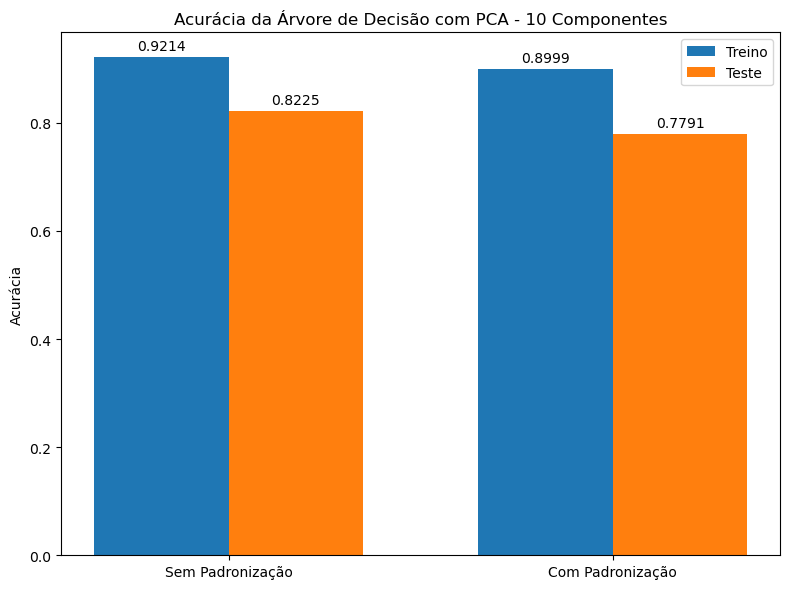

CPU times: total: 1.89 s
Wall time: 1.92 s


In [40]:
%%time
# 2. Treinando e avaliando a árvore de decisão

# Definir o classificador de árvore de decisão com ccp_alpha=0.001
clf_without_scaling = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)
clf_with_scaling = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)

# Treinando os modelos
clf_without_scaling.fit(X_train_pca_without_scaling, y_train)
clf_with_scaling.fit(X_train_pca_with_scaling, y_train)

# Predições
y_pred_train_without_scaling = clf_without_scaling.predict(X_train_pca_without_scaling)
y_pred_test_without_scaling = clf_without_scaling.predict(X_test_pca_without_scaling)

y_pred_train_with_scaling = clf_with_scaling.predict(X_train_pca_with_scaling)
y_pred_test_with_scaling = clf_with_scaling.predict(X_test_pca_with_scaling)

# 3. Calculando a acurácia

accuracy_train_without_scaling = accuracy_score(y_train, y_pred_train_without_scaling)
accuracy_test_without_scaling = accuracy_score(y_test, y_pred_test_without_scaling)

accuracy_train_with_scaling = accuracy_score(y_train, y_pred_train_with_scaling)
accuracy_test_with_scaling = accuracy_score(y_test, y_pred_test_with_scaling)

# 4. Exibindo os resultados
print("Árvore de Decisão com PCA (10 componentes) - SEM Padronização:")
print(f"Acurácia na base de treino: {accuracy_train_without_scaling:.4f}")
print(f"Acurácia na base de teste: {accuracy_test_without_scaling:.4f}")

print("\nÁrvore de Decisão com PCA (10 componentes) - COM Padronização:")
print(f"Acurácia na base de treino: {accuracy_train_with_scaling:.4f}")
print(f"Acurácia na base de teste: {accuracy_test_with_scaling:.4f}")

# 5. Visualizando os resultados
labels = ['Sem Padronização', 'Com Padronização']
train_accuracies = [accuracy_train_without_scaling, accuracy_train_with_scaling]
test_accuracies = [accuracy_test_without_scaling, accuracy_test_with_scaling]

x = np.arange(len(labels))  # O eixo x para as barras
width = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(8, 6))

# Barras de acurácia de treino e teste
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Treino')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Teste')

# Adicionando texto às barras
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia da Árvore de Decisão com PCA - 10 Componentes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Função para adicionar os rótulos nas barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Deslocamento do texto
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()